In [1]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import numpy as np
import scipy

print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("Python version:", sys.version)

NumPy version: 1.26.4
SciPy version: 1.13.1
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


In [18]:
n,d,k,tau = 50,12,1,100
W,Lambda = np.ones((d, k)),np.eye(k)
np.random.seed(101) #seed = 41,51,...


z = np.random.normal(0, 1, size=(n, k))
#ground_truth 
x0= np.dot(W,np.transpose(z))
norm_of_raw_data = np.linalg.norm(x0,ord=2)
x0.shape,norm_of_raw_data


((12, 50), 26.000079468217375)

In [19]:
# Seed
np.random.seed(450)


mean = np.zeros(d)  
cov = (1/tau) * np.eye(d)  
E = np.random.multivariate_normal(mean, cov, size= n).T
# contaminate 
x = x0+E
mu_z = np.full((n, k),0.1)

x.shape, mu_z.shape

((12, 50), (50, 1))

In [6]:
pip install cmdstanpy


Note: you may need to restart the kernel to use updated packages.


In [7]:
import cmdstanpy
cmdstanpy.install_cmdstan()


CmdStan install directory: /Users/arghyadatta/.cmdstan
CmdStan version 2.35.0 already installed
Test model compilation


True

In [28]:
import numpy as np
import cmdstanpy


X = x
nu = 10  

stan_data = {
    'n': X.shape[1],  
    'd': X.shape[0],  
    'k': k,           
    'X': X,
    'nu': nu         
}


stan_model_code = """
data {
  int<lower=1> d;            // number of rows in X
  int<lower=1> n;            // number of columns in X
  int<lower=1> k;            // rank of W and Z
  matrix[d, n] X;            // data matrix
  real<lower=0> nu;          // parameter nu
}

parameters {
  matrix[d, k] W;            // matrix W of size d x k
  matrix[n, k] Z;            // matrix Z of size n x k
  vector<lower=1e-6>[n] u;   // vector u of length n with Gamma prior, lower bound set to a small positive value
}

model {
  // Priors
  for (j in 1:k)
    W[:, j] ~ normal(0, 1);   // Prior on W
  for (i in 1:n)
    Z[i, ] ~ normal(0, 1);    // Prior on Z
  u ~ gamma(nu / 2, nu / 2);  // Gamma prior on u

  // Fixed tau = 100
  real tau = 100;

  // Likelihood
  for (i in 1:n) {
    matrix[d, d] cov_mat;   // Renamed to avoid conflicts with reserved keyword
    cov_mat = diag_matrix(rep_vector(1 / (tau * u[i]), d));
    X[, i] ~ multi_normal(W * Z[i, ]', cov_mat);
  }
}

generated quantities {
  matrix[d, n] X_hat;
  for (i in 1:n) {
    X_hat[, i] = W * Z[i, ]';  // Posterior predictive mean for X
  }
}
"""


with open('model.stan', 'w') as f:
    f.write(stan_model_code)


model = cmdstanpy.CmdStanModel(stan_file='model.stan')


fit = model.sample(data=stan_data, iter_sampling=200000, iter_warmup=100000, chains=4)


posterior = fit.stan_variable('X_hat')
posterior_mean = np.mean(posterior, axis=0)  # Mean of WZ' with respect to the posterior


print("Posterior mean of WZ':")
print(posterior_mean)

16:13:41 - cmdstanpy - INFO - compiling stan file /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model.stan to exe file /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model
16:13:57 - cmdstanpy - INFO - compiled model executable: /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model
16:13:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:50:48 - cmdstanpy - INFO - CmdStan done processing.



Posterior mean of WZ':
[[ 2.68044985  0.59789984  0.91375657  0.46575949  0.64695714 -0.31677922
  -0.87967401  0.59529157 -2.00401027  0.77643793  0.51946595 -0.5682224
   0.20361968 -0.72402786 -0.94246931  0.99122307  0.23765953  1.94200557
   2.5681196   0.69058956  0.32094514  1.68322951 -1.6792882  -1.12688877
  -0.1410027   0.3706875   0.10738821  0.19802288  0.8292373   0.07548148
   0.60821221  0.32483075 -0.46455439 -0.75520149 -0.91034748  0.49701317
  -0.127241    1.88958544  0.24307384  2.00107394 -1.0369137   0.18758311
  -1.12249436  0.00474391  0.98457493 -0.15496737 -0.04418997  0.65945772
   2.07711038 -0.64512172]
 [ 2.68987973  0.60000106  0.91697437  0.46739618  0.64923512 -0.31789402
  -0.88277003  0.59738514 -2.01105837  0.77916824  0.52129063 -0.57022351
   0.20433397 -0.72657598 -0.94578629  0.99470871  0.23849484  1.94883371
   2.5771542   0.69301832  0.32207282  1.68915189 -1.68519391 -1.13085053
  -0.14149825  0.37199103  0.10776885  0.19871895  0.83215353 

In [30]:
norm_of_esimated_data = np.linalg.norm((posterior_mean-x0),ord=2)
norm_of_esimated_data

0.6239638648228346

In [29]:
posterior_mean[:,25]

array([0.3706875 , 0.37199103, 0.38236134, 0.37646846, 0.37450974,
       0.37938233, 0.37413346, 0.38155672, 0.37421978, 0.37787864,
       0.37416927, 0.37571406])

In [26]:
x0[:,25]

array([0.39052784, 0.39052784, 0.39052784, 0.39052784, 0.39052784,
       0.39052784, 0.39052784, 0.39052784, 0.39052784, 0.39052784,
       0.39052784, 0.39052784])

In [31]:
posterior_mean.shape


(12, 50)

In [50]:
import numpy as np
import cmdstanpy
X = x
nu = 10  

stan_data = {
    'n': X.shape[1],  # Number of columns in X
    'd': X.shape[0],  # Number of rows in X
    'k': k,           # Rank of W and Z
    'X': X,
    'nu': nu         # Include nu in the data
}

stan_model_code = """
data {
  int<lower=1> d;            // number of rows in X
  int<lower=1> n;            // number of columns in X
  int<lower=1> k;            // rank of W and Z
  matrix[d, n] X;            // data matrix
  real<lower=0> nu;          // parameter nu
}

parameters {
  matrix[d, k] W;            // matrix W of size d x k
  matrix[n, k] Z;            // matrix Z of size n x k
  vector<lower=1e-6>[n] u;   // vector u of length n with Gamma prior, lower bound set to a small positive value
}

model {
  // Priors
  for (j in 1:k)
    W[:, j] ~ normal(0, 1);   // Prior on W
  for (i in 1:n)
    Z[i, ] ~ normal(0, 1);    // Prior on Z
  u ~ gamma(nu / 2, nu / 2);  // Gamma prior on u

  // Fixed tau = 100
  real tau = 100;

  // Likelihood
  for (i in 1:n) {
    matrix[d, d] cov_mat;   // Renamed to avoid conflicts with reserved keyword
    cov_mat = diag_matrix(rep_vector(1 / (tau * u[i]), d));
    X[, i] ~ multi_normal(W * Z[i, ]', cov_mat);
  }
}

generated quantities {
  matrix[d, n] X_hat;
  for (i in 1:n) {
    X_hat[, i] = W * Z[i, ]';  // Posterior predictive mean for X
  }
}
"""

with open('model.stan', 'w') as f:
    f.write(stan_model_code)


model = cmdstanpy.CmdStanModel(stan_file='model.stan')


fit = model.variational(data=stan_data, algorithm='meanfield', iter=11600)


posterior = fit.stan_variable('X_hat')

# Debugging: Print the shape of the posterior
print("Shape of posterior:", posterior.shape)


try:
    posterior_mean = posterior.reshape(d, n)  # Ensure correct shape (12, 50)
    print("Posterior mean of WZ' using ADVI:")
    print(posterior_mean)
except ValueError as e:
    print(f"Error reshaping posterior: {e}")
    print("Posterior:", posterior)  


18:39:02 - cmdstanpy - INFO - compiling stan file /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model.stan to exe file /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model
18:39:19 - cmdstanpy - INFO - compiled model executable: /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:21 - cmdstanpy - INFO - Chain [1] done processing
18:39:21 - cmdstanpy - WARNING - The default behavior of CmdStanVB.stan_variable() will change in a future release to return the variational sample, rather than the mean.
To maintain the current behavior, pass the argument mean=True


Shape of posterior: (12, 50)
Posterior mean of WZ' using ADVI:
[[ 2.68168     0.599418    0.907439    0.467065    0.645085   -0.324932
  -0.881985    0.602341   -1.98799     0.7723      0.52559    -0.565478
   0.203656   -0.718919   -0.942947    0.985725    0.239538    1.94638
   2.57186     0.696165    0.312877    1.67035    -1.68081    -1.13448
  -0.144985    0.367197    0.107558    0.189026    0.826772    0.0781469
   0.60576     0.321209   -0.470741   -0.754681   -0.908208    0.499127
  -0.135848    1.88385     0.247198    1.9983     -1.04177     0.188531
  -1.11848     0.00600602  0.983597   -0.158352   -0.0510705   0.661109
   2.06684    -0.637348  ]
 [ 2.68062     0.599181    0.907081    0.46688     0.644831   -0.324804
  -0.881637    0.602104   -1.9872      0.771995    0.525383   -0.565255
   0.203575   -0.718636   -0.942575    0.985336    0.239444    1.94561
   2.57085     0.69589     0.312754    1.66969    -1.68015    -1.13403
  -0.144928    0.367052    0.107515    0.188952  

In [51]:
norm_of_esimated_data = np.linalg.norm((posterior_mean-x0),ord=2)
norm_of_esimated_data

0.6249433249267484

In [35]:
posterior_mean[:,25]

array([0.382044, 0.377713, 0.395951, 0.389464, 0.375891, 0.389409,
       0.385209, 0.39236 , 0.385713, 0.381297, 0.382918, 0.381011])

In [74]:
import numpy as np
import cmdstanpy

X = x
nu = 10  

stan_data = {
    'n': X.shape[1],  # Number of columns in X
    'd': X.shape[0],  # Number of rows in X
    'k': k,           # Rank of W and Z
    'X': X,
    'nu': nu         # Include nu in the data
}


stan_model_code = """
data {
  int<lower=1> d;            // number of rows in X
  int<lower=1> n;            // number of columns in X
  int<lower=1> k;            // rank of W and Z
  matrix[d, n] X;            // data matrix
  real<lower=0> nu;          // parameter nu
}

parameters {
  matrix[d, k] W;            // matrix W of size d x k
  matrix[n, k] Z;            // matrix Z of size n x k
  vector<lower=1e-6>[n] u;   // vector u of length n with Gamma prior, lower bound set to a small positive value
}

model {
  // Priors
  for (j in 1:k)
    W[:, j] ~ normal(0, 1);   // Prior on W
  for (i in 1:n)
    Z[i, ] ~ normal(0, 1);    // Prior on Z
  u ~ gamma(nu / 2, nu / 2);  // Gamma prior on u

  // Fixed tau = 100
  real tau = 100;

  // Likelihood
  for (i in 1:n) {
    matrix[d, d] cov_mat;   // Renamed to avoid conflicts with reserved keyword
    cov_mat = diag_matrix(rep_vector(1 / (tau * u[i]), d));
    X[, i] ~ multi_normal(W * Z[i, ]', cov_mat);
  }
}

generated quantities {
  matrix[d, n] X_hat;
  for (i in 1:n) {
    X_hat[, i] = W * Z[i, ]';  // Posterior predictive mean for X
  }
}
"""


with open('model.stan', 'w') as f:
    f.write(stan_model_code)


model = cmdstanpy.CmdStanModel(stan_file='model.stan')


try:
    fit = model.variational(
        data=stan_data,
        algorithm='meanfield',
        iter=20000,
        require_converged=False
    )
    posterior = fit.stan_variable('X_hat')

    print("Shape of posterior:", posterior.shape)
    

    try:
        d = X.shape[0]  
        n = X.shape[1]  
        posterior_mean = posterior.reshape(d, n)  
        print("Posterior mean of WZ' using ADVI:")
        print(posterior_mean)
    except ValueError as e:
        print(f"Error reshaping posterior: {e}")
        print("Posterior:", posterior) 

except RuntimeError as e:
    print(f"ADVI did not converge: {e}")


14:41:40 - cmdstanpy - INFO - compiling stan file /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model.stan to exe file /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model
14:41:57 - cmdstanpy - INFO - compiled model executable: /Users/arghyadatta/Downloads/Probabilistic-and-Bayesian-PCA-master/model
14:41:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - WARNING - The default behavior of CmdStanVB.stan_variable() will change in a future release to return the variational sample, rather than the mean.
To maintain the current behavior, pass the argument mean=True


Shape of posterior: (12, 50)
Posterior mean of WZ' using ADVI:
[[ 2.68888e+00  6.08639e-01  9.43261e-01  4.40258e-01  6.50739e-01
  -2.87028e-01 -8.65623e-01  6.02274e-01 -2.00354e+00  7.82987e-01
   5.28141e-01 -5.81209e-01  2.18432e-01 -7.16025e-01 -9.35909e-01
   9.76249e-01  2.39451e-01  1.97751e+00  2.58034e+00  7.14490e-01
   3.34177e-01  1.70888e+00 -1.68957e+00 -1.14131e+00 -1.49117e-01
   3.80815e-01  1.08697e-01  1.90927e-01  8.23823e-01  1.10130e-01
   6.43978e-01  3.35739e-01 -4.52906e-01 -7.68355e-01 -9.05794e-01
   5.11906e-01 -1.34193e-01  1.92027e+00  2.36617e-01  2.00324e+00
  -1.04181e+00  2.06074e-01 -1.13368e+00 -2.72747e-04  9.87114e-01
  -1.58327e-01 -5.08790e-02  6.57227e-01  2.10624e+00 -6.35741e-01]
 [ 2.72005e+00  6.15694e-01  9.54195e-01  4.45361e-01  6.58282e-01
  -2.90355e-01 -8.75656e-01  6.09255e-01 -2.02677e+00  7.92062e-01
   5.34263e-01 -5.87946e-01  2.20963e-01 -7.24324e-01 -9.46757e-01
   9.87564e-01  2.42227e-01  2.00043e+00  2.61025e+00  7.22772e-0

In [75]:
norm_of_error_esimated_data = np.linalg.norm((posterior_mean-x0),ord=2)
norm_of_error_esimated_data

0.7339150325187926

<IPython.core.display.Javascript object>


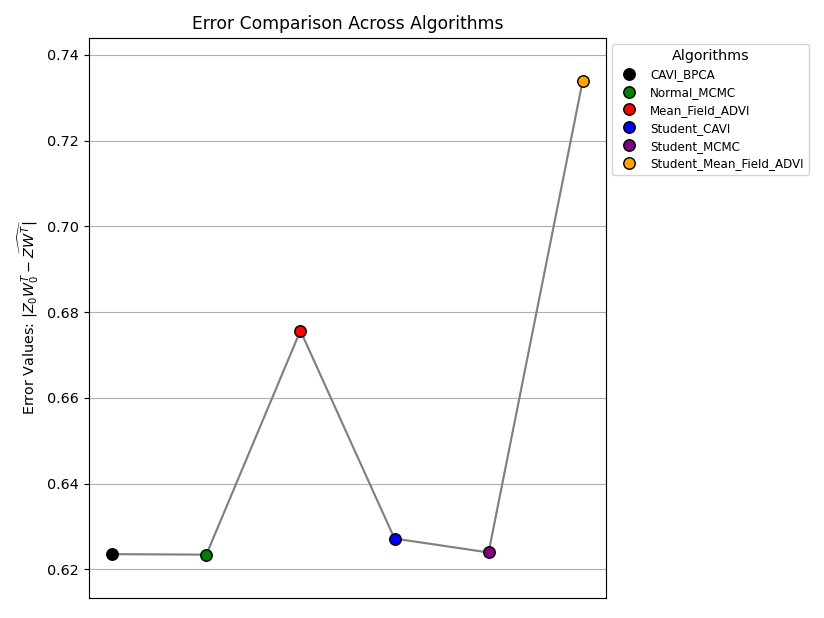

In [78]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


algorithms = ['CAVI_BPCA', 'Normal_MCMC', 'Mean_Field_ADVI', 'Student_CAVI', 'Student_MCMC', 'Student_Mean_Field_ADVI']
errors = [0.62357085, 0.623449, 0.67567653, 0.6272, 0.62396, 0.733915]

colors = ['black', 'green', 'red', 'blue', 'purple', 'orange']


plt.figure(figsize=(8, 6), dpi=103)


plt.plot(range(len(errors)), errors, marker='o', linestyle='-', color='grey')


for i, (alg, err, color) in enumerate(zip(algorithms, errors, colors)):
    plt.plot(i, err, marker='o', color=color, markersize=8, markeredgecolor='black')


plt.ylim([min(errors) - 0.01, max(errors) + 0.01])
plt.ylabel('Error Values: $\|Z_0W_0^T-\widehat{ZW^T}\|$')
plt.title('Error Comparison Across Algorithms')


plt.xticks([])


for i, alg in enumerate(algorithms):
    plt.plot([], [], 'o', label=f'{alg}', markersize=8, color=colors[i], markeredgecolor='black')

legend = plt.legend(title='Algorithms', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title_fontsize='medium')


for text in legend.get_texts():
    text.set_color('black')

plt.grid(True)
plt.tight_layout()  
plt.show()

In [ ]:
[CAVI_BPCA, Normal_MCMC, MF_ADVI, Student_CAVI, Student_MCMC, Student_MF_ADVI ] = 
[0.62357085, 0.623449, 0.67567653, 0.6272, 0.62396, 0.733915]